### Import modules

In [2]:
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command():
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    query = '''
    SELECT name, type
    FROM sqlite_master 
    WHERE type IN ("table","view");
    '''
    return run_query(query)
        
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Genres and selling

In [4]:
query = '''
WITH tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from tracks_sold
    ) percentage_sold
FROM tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''
genre_sold = run_query(query)
genre_sold

,genre,tracks_sold,percentage_sold
0,Rock,2635,0.553921
1,Metal,619,0.130124
2,Alternative & Punk,492,0.103427
3,Latin,167,0.035106
4,R&B/Soul,159,0.033424
5,Blues,124,0.026067
6,Jazz,121,0.025436
7,Alternative,117,0.024595
8,Easy Listening,74,0.015556
9,Pop,63,0.013244


### Genres and selling barplot

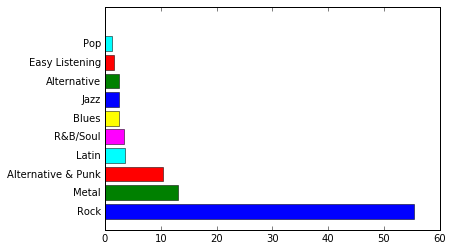

In [5]:
import numpy as np

bar_width = genre_sold.iloc[:,2] * 100
height = 0.8
bar_positions = np.arange(10) + 1
colors = ["blue", "green", "red", "cyan", "magenta", "yellow"]
labels = genre_sold.iloc[:,0]

plt.barh(bar_positions, bar_width, height, align='center', color = colors, linewidth = 0.5, tick_label = labels)
plt.tick_params(left="off", right="off")

### Agent sales performance

In [5]:
agent_sales_performance = '''
WITH 
    customer_sales AS
        (
        SELECT
            i.customer_id,
            c.support_rep_id,
            SUM(i.total) total
        FROM invoice i
        INNER JOIN customer c ON i.customer_id = c.customer_id
        GROUP BY 1,2
        )
        
SELECT
    e.first_name || " " || e.last_name emp_name,
    e.hire_date,
    SUM(cs.total) total_sales
FROM customer_sales cs
INNER JOIN employee e ON e.employee_id = cs.support_rep_id
GROUP BY 1
'''

agent_sales = run_query(agent_sales_performance)
agent_sales

,emp_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


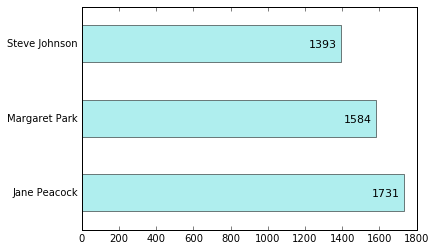

In [6]:
import numpy as np

bar_width = agent_sales.iloc[:,2]
bar_positions = np.arange(agent_sales.shape[0])
height = 0.5
labels = agent_sales.iloc[:,0]

plt.barh(bar_positions, bar_width, height, align='center', color = "paleturquoise", linewidth = 0.5, tick_label = labels)
plt.tick_params(left="off", right="off")

for i in range(agent_sales.shape[0]):
    plt.text(x = bar_width[i]-175, y = bar_positions[i]-0.05, s = int(bar_width[i]), size = 11)

Top employee is Jane Peacock. Bottom employee Steve Johnson has less total dollar amount of sales, but he was 

### Sales by country

In [7]:
country_purchases = '''
WITH sales_country AS
    (SELECT
        CASE
            WHEN (
                SELECT count(*)
                FROM customer
                where country = c.country
                ) = 1 THEN "Other"
            ELSE c.country
        END AS country,
        count(c.customer_id) cust_amount,
        sum(i.total) country_sum,
        sum(i.total) / count(c.customer_id) avg_sale,
        sum(i.total) / count(i.invoice_id) avg_order
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY country)
    
SELECT
    country,
    cust_amount customers,
    country_sum,
    avg_sale,
    avg_order,
    CASE
        WHEN country = "Other" THEN 1
        ELSE 0
    END AS sort
FROM sales_country
GROUP BY country
ORDER BY customers DESC, country ASC
'''

country_sales = run_query(country_purchases)
country_sales

,country,customers,country_sum,avg_sale,avg_order,sort
0,USA,131,1040.49,7.942672,7.942672,0
1,Canada,76,535.59,7.047237,7.047237,0
2,Brazil,61,427.68,7.011148,7.011148,0
3,France,50,389.07,7.781400,7.781400,0
4,Germany,41,334.62,8.161463,8.161463,0
5,Czech Republic,30,273.24,9.108000,9.108000,0
6,Portugal,29,185.13,6.383793,6.383793,0
7,United Kingdom,28,245.52,8.768571,8.768571,0
8,India,21,183.15,8.721429,8.721429,0
9,Other,10,75.24,7.524000,7.524000,1


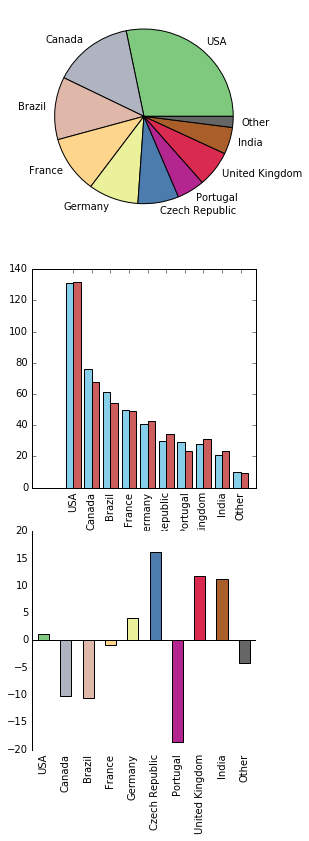

In [40]:
fig = plt.figure(figsize=(4, 18))

ax1 = fig.add_subplot(4, 1, 1)
fraction = country_sales.iloc[:,2] / 7.9
labs = country_sales.iloc[:,0]
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_sales.shape[0])]
ax1.pie(fraction, labels = labs, colors = colors)

ax2 = fig.add_subplot(4, 1, 2)
customers = country_sales.iloc[:,1]
width = 0.4
bar_positions = np.arange(country_sales.shape[0])
ax2.bar(bar_positions - width/2, customers, width, color='SkyBlue')
ax2.bar(bar_positions + width/2, fraction, width, color='IndianRed')
ax2.set_xticklabels(labs, rotation='vertical')
ax2.set_xticks(bar_positions + width/2)

ax3 = fig.add_subplot(4, 1, 3)
avg_order = country_sales["avg_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)
ax3.set_xticklabels(labs, rotation='vertical')
ax3.set_xticks(bar_positions)

### Albums vs Individual Tracks

In [8]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668
